## Phase diagram from first principle calculation

Author: **S. Jung (v1, Apr14.2025., v1.1 May07.2025.)**
Revision: **S. Tiwari (TBA)**

In this Noteboook, we compute the Gibbs free energy of magnesium using the _ab initio_ calculation. Electrons and phonons are computed with Quantum ESPRESSO (QE), electronic and vibrational entropy are computed with quasi-harmonic approximation (QHA). Finally, pressure-temperature phase diagram is drawn

### Theory

Here, we briefly introduce the main concepts and equations used in QE to obtain the Gibbs free energy. To draw a phase diagram, we need the Gibbs free energy for two different phases at a given temperature and pressure. The Gibbs free energy is given by
$${G}(p,T) = {F}(p,T) + pV,$$
where $G(p,T)$ and $F(p,T)$ are the Gibbs and Helmholtz free energies at a given temperature ($T$) and pressure ($p$), respectively. To evaluate $F$, we need the volume ($V$) and pressure ($p$), which can be obtained from the gradient of the $V$–$F$ curve. The Helmholtz free energy $F$ can be expressed as
$${F}(p,T) = {F}(p;V,T) = {U}_{0}(V) + {F}_{\mathrm{vib}}(V,T) + {F}_{\mathrm{elec}}(V,T),$$
where $U_{0}$, ${F}_{\mathrm{vib}}$, and ${F}_{\mathrm{elec}}$ are the internal, vibrational, and electronic free energies, respectively. $U_{0}$ can be calculated using self-consistent field (SCF) calculations. The remaining two contributions to the free energy are derived from the phonon and electronic density of states (DOS). 

First, the vibrational free energy is given by
$${F}_{\mathrm{vib}}(V,T) = {E}_{\mathrm{zpe}}(V) - T{S}_{\mathrm{vib}}(V,T),$$
where ${E}_{\mathrm{zpe}}$ and ${S}_{\mathrm{vib}}$ are the zero-point energy and vibrational entropy, respectively. These quantities can be expressed using the phonon frequency ($\omega_{\mathbf{q}\nu}$) for a given wavevector ($\mathbf{q}$) and phonon mode ($\nu$),
$${E}_{\mathrm{zpe}} = \sum_{\mathbf{q},\nu} \cfrac{\hbar \omega_{\mathbf{q}\nu}}{2}, $$
$${S}_{\mathrm{vib}} = -k_{B} \sum_{\mathbf{q},\nu} \log \left[ 1 - \exp \left( -\cfrac{\hbar \omega_{\mathbf{q}\nu}}{k_{B}T} \right) \right]. $$

In this notebook, these equations are implemented using the phonon DOS instead of the individual phonon frequencies $\omega_{\mathbf{q}\nu}$,
$${E}_{\mathrm{zpe}} = \cfrac{1}{2} \int_{0}^{\infty} dE\, E\, g_{p}(E), $$
$${S}_{\mathrm{vib}} = M \int_{0}^{\infty} dE\, \log(1 + n(E))\, g_{p}(E), $$
where $E$, $g_{p}$, and $n$ denote the phonon energy, phonon DOS, and the Bose–Einstein distribution function, respectively. $M$ represents the number of atoms in the unit cell, but $M$ can be ignored since QE automatically normalizes the phonon DOS to the total number of phonon modes.

On the other hand, the electronic free energy is given by
$${F}_{\mathrm{elec}}(V,T) = {E}_{\mathrm{exct}}(V,T) - T{S}_{\mathrm{elec}}(V,T),$$
where ${E}_{\mathrm{exct}}$ and ${S}_{\mathrm{elec}}$ are the electronic excitation energy and entropy, respectively.
$${E}_{\mathrm{exct}} = \int_{-\infty}^{\infty} d\varepsilon\, \varepsilon\, g_{e}(\varepsilon) f(\varepsilon) - \int_{-\infty}^{E_{F}} d\varepsilon\, \varepsilon\, g_{e}(\varepsilon),$$
$${S}_{\mathrm{elec}} = -k_{B} \int_{-\infty}^{\infty} d\varepsilon \left[ f(\varepsilon)\log(f(\varepsilon)) + (1 - f(\varepsilon))\log(1 - f(\varepsilon)) \right] g_{e}(\varepsilon),$$
where $\varepsilon$, $g_{e}$, and $f$ represent the electronic energy, electronic DOS, and the Fermi–Dirac distribution function, respectively.

Finally, we obtain $F(V,T)$ for each phase. This $F(V,T)$ is then interpolated and expressed as a function of pressure, i.e., $F(p;V,T)$. The final step is to compare the Gibbs free energies $G$ of the different phases at a given temperature and pressure.

### Calculation steps
1. Construct a volume set for each phase via structural relaxation calculations under pressure. (`pw.x`)
2. Perform phonon dispersion and DOS calculations. (`ph.x`, `q2r.x`, and `matdyn.x`)
3. Conduct non-self-consistent field (NSCF) and electronic DOS calculations. (`pw.x` and `dos.x`)
4. Calculate the zero-point energy and vibrational entropy from step 2.
5. Calculate the electronic excitation energy and entropy from step 3.
6. Using the results from steps 4 and 5, calculate and interpolate the Helmholtz free energy as a function of pressure.
7. Finally, compute and compare the Gibbs free energy of each phase.

### Basic steups
We need to set paths, constants, pararellization parameters.

In [2]:
import os
import math
import numpy as np
import EPWpy
from EPWpy import EPWpy
from EPWpy.QE.PW_util import *
from scipy.integrate import simpson
from scipy.interpolate import interp1d

# Set your pseudopotential dir. This tutorial use LDA 
# paramiterized by Pseudodojo
pseudo = '/work2/08400/jsyeb/frontera/epwpy/pseudos'
workdir = '/scratch/08400/jsyeb/'
cores = 48
bccnk = 24
hcpnk = 12

In [3]:
# Move to your working directory and make dirs for each phase
os.chdir(workdir)
os.mkdir("mg-epwpy")
os.chdir("./mg-epwpy")
os.mkdir("bcc")
os.mkdir("hcp")

In [4]:
# Set constant values
kb = 8.617333E-05   # Boltzmann [eV/K]
ry2ev = 13.6057     # rydberg to electronvolt
ry2cmm1 = 109677.57 # rydberg to cm-1
ry2k = 157887.6634  # rydberg to kelvin
# this constant standing for Ry/bohr3 -> kbar
pressunit = 147105.371715 # pressure unit conversion

### Input values
The following are input values. All values depend on the specific system and the pseudopotential used. You can manually control how many volume and temperature points are considered.

In [5]:
# Set input values
bccnatom = 1.0  # number of atoms for BCC Mg
hcpnatom = 2.0  # number of atoms for HCP Mg
bccnelec = 10.0 # number of electrons for BCC Mg
hcpnelec = 20.0 # number of electrons for HCP Mg

numvol = 6      # numver of volume to consider
ntemp = 50      # number of temperature to consider
tstep = 40.0    # temperature interval

pmin = 50.0     # minimum pressure value
pmax = 550.0    # maximum pressure value
pstep = 5.0     # pressure interval

In [6]:
# We will consider six different volume and 20 temperature points
# for each BCC and HCP Mg:
bcclat = [None]*numvol
bccenergy = [None]*numvol
bcchelm = [[0.0 for x in range(numvol)] for y in range(ntemp)]
bccgibbs = [[0.0 for x in range(numvol)] for y in range(ntemp)]
hcplat = [None]*numvol
hcpcoa = [None]*numvol
hcpenergy = [None]*numvol
hcphelm = [[0.0 for x in range(numvol)] for y in range(ntemp)]
hcpgibbs = [[0.0 for x in range(numvol)] for y in range(ntemp)]
# interpolation arrays:
bccvol = [None]*numvol
hcpvol = [None]*numvol
bccitpv = [None]*ntemp
hcpitpv = [None]*ntemp
bccpress = [[0.0 for x in range(numvol)] for y in range(ntemp)]
hcppress = [[0.0 for x in range(numvol)] for y in range(ntemp)]
bccitpg = [None]*ntemp
hcpitpg = [None]*ntemp
# Set volume and phase boundary arrays:
nump = int((pmax - pmin)/pstep)
press = [None]*nump
pb = [None]*nump
top = [None]*nump

### BCC Mg calculaions
First, we define the general calculation parameters for body-centered cubic (BCC) magnesium (Mg).

In [7]:
bccrelax=EPWpy.EPWpy({'prefix':'\'bccrelax\'','restart_mode':'\'from_scratch\'',
                      'calculation':'\'scf\'',
                      'ibrav':3,'celldm(1)':'6.41680','ntyp':1,'nat':1,
                      'atomic_species':['Mg'],'mass':[24.305],'atoms':['Mg'],'pseudo':['Mg.upf'],
                      'atomic_pos':np.array([[0.0, 0.0, 0.0]]),'atomic_position_type':'crystal',
                      'ecutwfc':'100','occupations':'\'smearing\'','smearing':'\'gaussian\'','degauss':'0.05',
                      'verbosity':'\'low\'','pseudo_dir':'\''+str(pseudo)+'\''
                     },env='mpirun',system='bccrelax')

bccrelax.run_serial = True
bccrelax.verbosity = 2
bccrelax.iondynamics = True
bccrelax.celldynamics = True


                                                                                                                         
                                                                                          
                                       -*#*-                             ...............- 
                          .+*=      .+%*-=%%:      .=#*-               -===============-:.
                        :*%=*%%-    *%*   #%*    :+%+-%%+             .:.  -=.   :==-.    
                        -%S  -%%*: :#%.   -%%-. -##:  #%*                  -=.   :==-     
                ..      .%S:   +%%%%*.     :*%%%#=    %%=                  -=.   :==-     
              :=#%%*-   .#S-     ..                  .%%=     :*#*:        -=.   :==-     
             -%S:.=#%%*==%#                           *%%=::=##-+%%.  .   .=-.   :==-  .= 
             :%%-   .-+++:                             -+##*=.  =%S   :-::==:    .==-  --.
              *%#                                         

### Structure relaxation calculations with pressure
Relax the BCC Mg lattice parameter without applying external pressure. All subsequent relaxation calculations under finite pressure will be carried out. Each calculation is named according to its pressure value in kbar.

In [8]:
bccrelax.scf(ions={'ion_dynamics':'bfgs'},
             cell={'press':'0','press_conv_thr':'0.1'},
             system={'nbnd':10},
             control = {'calculation':'\'vc-relax\'','nstep':50},
             electrons = {'conv_thr':'1E-12'},
             kpoints={'kpoints':[[12,12,12]]},
             name = '0')
bccrelax.prepare(cores,'scf',infile = '0.in')
bccrelax.run(cores,'scf',infile='0')

-- -- -- -- -- -- -- -- -- -- --  Calculation: 0  -- -- -- -- -- -- -- -- -- -- -- 
on 1: running:  mpirun -np 48 /work2/08400/jsyeb/frontera/epwpy/build/q-e-EPW-5.9s/bin/pw.x -nk 48 -nt 1 -in  0.in > 0.out
Running 0 |████████████████████████████████████████| in 14.5s (0.10/s)          

-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 


Now, we have relaxed BCC Mg structure, and we will check the values. All the values should be zero, because this was a first calculation of this tutorial.

In [9]:
bccrelax.pw_util = bccrelax.PW_utilities()
print(bccrelax.pw_cell_parameters)
print('old_positions:', bccrelax.pw_atomic_positions['atomic_pos'])
print('old_cell_parameters:', bccrelax.pw_cell_parameters['lattice_vector'])

{'cell_type': 'alat', 'lattice_vector': array([['0.000 0.000 0.000'],
       ['0.000 0.000 0.00'],
       ['0.000 0.000 0.000']], dtype='<U17')}
old_positions: [[0. 0. 0.]]
old_cell_parameters: [['0.000 0.000 0.000']
 ['0.000 0.000 0.00']
 ['0.000 0.000 0.000']]


We can check the change of lattice parameter by comparing first and second line of the output. At the first, our input has lattice parameter 1 with `(0.5,0.5,0,5)` vector in unit of alat. After relax calculation, the second line informs that lattice 1 has become `(0.518083,0.518083,0.518083)`.

In [10]:
bccrelax.pw_cell_parameters['lattice_vector'] = obtain_cell_parameters(bccrelax.pw_util.file)
print('new_cell_parameters:', bccrelax.pw_cell_parameters['lattice_vector'])

['a(1)', '=', '(', '0.500000', '0.500000', '0.500000', ')']
['a(1)', '=', '(', '0.518083', '0.518083', '0.518083', ')']
new_cell_parameters: [[ 1.75921454  1.75921454  1.75921454]
 [-1.75921454  1.75921454  1.75921454]
 [-1.75921454 -1.75921454  1.75921454]]


We can apply pressure to the relax calculation. For automatic calculation, the relax calculation setup will be recycled with a loop. We consider six differet pressure from 50 to 550 kbar, and each relax calculation will give us lattice parameter at given pressure.

In [11]:
for prs in range(50, 650, 100):
    bccrelax.scf(ions={'ion_dynamics':'bfgs'},
                 cell={'press':''+str(prs)+'','press_conv_thr':'0.1'},
                 control = {'calculation':'\'vc-relax\'','nstep':50},
                 system={'nbnd':10},
                 electrons = {'conv_thr':'1E-12'},
                 kpoints={'kpoints':[[12,12,12]]},
                 name = ''+str(prs)+'')
    bccrelax.prepare(cores,'scf',infile = ''+str(prs)+'.in')
    bccrelax.run(cores,'scf',infile=''+str(prs)+'')
    bccrelax.pw_util = bccrelax.PW_utilities()
    bccrelax.pw_cell_parameters['lattice_vector'] = obtain_cell_parameters(bccrelax.pw_util.file)
    print('new_cell_parameters:', bccrelax.pw_cell_parameters['lattice_vector'])

-- -- -- -- -- -- -- -- -- -- --  Calculation: 50  -- -- -- -- -- -- -- -- -- -- -- 
on 1: running:  mpirun -np 48 /work2/08400/jsyeb/frontera/epwpy/build/q-e-EPW-5.9s/bin/pw.x -nk 48 -nt 1 -in  50.in > 50.out
Running 50 |████████████████████████████████████████| in 3.3s (0.53/s)          

-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 
['a(1)', '=', '(', '0.500000', '0.500000', '0.500000', ')']
['a(1)', '=', '(', '0.500000', '0.500000', '0.500000', ')']
new_cell_parameters: [[ 1.69781149  1.69781149  1.69781149]
 [-1.69781149  1.69781149  1.69781149]
 [-1.69781149 -1.69781149  1.69781149]]
-- -- -- -- -- -- -- -- -- -- --  Calculation: 150  -- -- -- -- -- -- -- -- -- -- -- 
on 1: running:  mpirun -np 48 /work2/08400/jsyeb/frontera/epwpy/build/q-e-EPW-5.9s/bin/pw.x -nk 48 -nt 1 -in  150.in > 150.out
Running 150 |████████████████████████████████████████| in 5.2s (0.30/s)         

-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 

The relaxed lattice parameters are saved as an array.

In [12]:
# Save the relaxed lattice parameters as a array manually
bcclat =[6.41680,6.13032,5.94124,5.79916,5.68522,5.59006]

In [13]:
# Move to BCC workplace
os.chdir(workdir)
os.chdir("./mg-epwpy/bcc/")
cwd = os.getcwd()
print(cwd)

/scratch/08400/jsyeb/mg-epwpy/bcc


### SCF, phonon, band, and DOS calculations
Here, we enter the main loop over `numvol`, performing SCF and phonon calculations. This is one of the most powerful features of epwpy. An outer loop over volume is constructed to sequentially run SCF, NSCF, electronic DOS, phonon, and phonon DOS calculations. Each volume is calculated in its own independent directory.

In [14]:
for i in range(0, numvol):
    # Define bcc calculation as a function of lattice parameter
    bcc=EPWpy.EPWpy({'prefix':'\'bcc'+str(i)+'\'','restart_mode':'\'from_scratch\'',
                     'calculation':'\'scf\'',
                     'ibrav':3,'celldm(1)':''+str(bcclat[i])+'','ntyp':1,'nat':1,
                     'atomic_species':['Mg'],'mass':[24.305],'atoms':['Mg'],'pseudo':['Mg.upf'],
                     'atomic_pos':np.array([[0.0, 0.0, 0.0]]),'atomic_position_type':'crystal',
                     'ecutwfc':'100','occupations':'\'smearing\'',
                     'smearing':'\'gaussian\'','degauss':'0.05',
                     'verbosity':'\'low\'','pseudo_dir':'\''+str(pseudo)+'\''
                     },env='mpirun',system='bcc'+str(i)+'')
    # SCF block
    bcc.run_serial = True
    bcc.Run.serial = True
    bcc.verbosity = 2
    bcc.Run.verbosity = 2
    bcc.scf(control = {'calculation':'\'scf\''},system={'nbnd':10},
            electrons = {'conv_thr':'1E-12'},kpoints={'kpoints':[[12,12,12]]},
            name = 'bcc'+str(i)+'')
    bcc.prepare(1,type_run='scf',infile = 'bcc'+str(i)+'.in')
    bcc.run(cores,type_run='scf',infile='bcc'+str(i)+'',parallelization='-nk '+str(bccnk)+'')
    # NB: We need the total energy values to calculate Gibbs free energies.
    bcc.pw_util = bcc.PW_utilities()
    print('Total Energy: ',bcc.pw_util.total_energy)
    bccenergy[i]=bcc.pw_util.total_energy
    # Electronic density of state (DOS) block
    bcc.scf(control = {'calculation':'\'nscf\''},system={'nbnd':10},
            electrons = {'conv_thr':'1E-12'},kpoints={'kpoints':[[24,24,24]]},
            name = 'nscf')
    bcc.prepare(1,type_run='nscf',infile = 'nscf.in')
    bcc.run(cores,type_run='nscf',infile = 'nscf',parallelization='-nk '+str(bccnk)+'')
    bcc.dos(dos={'DeltaE':'0.01','degauss':'0.02'})
    # NB: The DOS calculation was implemented by using manual call in EPWpy.
    #     Following six lines could be change in future.
    bcc.set_work()
    bcc.Prepare.prepare_dos(name = 'nscf')
    bcc.set_home()
    bcc.set_work()
    bcc.Run.run_dos(type_run='nscf',name='dos')
    bcc.set_home()
    # Phonon block
    bcc.ph(phonons={'fildyn':'"bcc'+str(i)+'.dyn"','nq1':3,'nq2':3,'nq3':3,
                    'fildvscf':'"dvscf"','tr2_ph':'1.0d-14'})
    bcc.prepare(1,type_run='ph')
    bcc.run(cores,type_run='ph',parallelization='-nk '+str(bccnk)+'')
    # q2r and matdyn block
    bcc.q2r(name='q2r')
    bcc.prepare(type_run='q2r')
    bcc.run(1,type_run='q2r')
    bcc.matdyn(name='matdyn',matdyn={'flfrq':'\'bcc'+str(i)+'.freq\''},
               kpoints={'kpoints':[
                   ['0.00','0.00','0.00','20'],
                   ['-0.50','0.50','0.50','20'],
                   ['0.00','0.50','0.00','20'],
                   ['0.00','0.00','0.00','20'],
                   ['0.25','0.25','0.25','20']
               ],
                        'kpoints_type':'{crystal_b}'
                       },
              )
    bcc.prepare(type_run='matdyn')
    bcc.run(1,type_run='matdyn')
    # Phonon DOS block
    bcc.phdos(name='phdos',phdos={'flfrq':'\'bcc'+str(i)+'.dos.freq\'','flfrc':'\'bcc'+str(i)+'.fc\'','asr':'\'simple\'',
                                  'fldos':'\'bcc'+str(i)+'.dos\'','dos':'.true.','nk1':30,'nk2':30,'nk3':30})
    bcc.prepare(type_run='phdos')
    bcc.run(1,type_run='phdos')


                                                                                                                         
                                                                                          
                                       -*#*-                             ...............- 
                          .+*=      .+%*-=%%:      .=#*-               -===============-:.
                        :*%=*%%-    *%*   #%*    :+%+-%%+             .:.  -=.   :==-.    
                        -%S  -%%*: :#%.   -%%-. -##:  #%*                  -=.   :==-     
                ..      .%S:   +%%%%*.     :*%%%#=    %%=                  -=.   :==-     
              :=#%%*-   .#S-     ..                  .%%=     :*#*:        -=.   :==-     
             -%S:.=#%%*==%#                           *%%=::=##-+%%.  .   .=-.   :==-  .= 
             :%%-   .-+++:                             -+##*=.  =%S   :-::==:    .==-  --.
              *%#                                         

### Calculation of vibrational entropy
This section provides a short code to calculate the zero-point energy and vibrational entropy, as described in the theory section.

In [15]:
for v in range(0, numvol):
    # Go to actual working dir
    os.chdir(workdir)
    os.chdir('./mg-epwpy/bcc/bcc'+str(v)+'/ph')
    
    # Read phonon DOS result
    pdata = []
    with open('bcc'+str(v)+'.dos', 'r') as f:
        next(f)
        for line in f:
            row = [float(x) for x in line.split()]
            pdata.append(row)
    if abs(pdata[0][0]) < 0.01:
        pdata[0][0] = 0.0
    numpdat = len(pdata)
    
    # Set data arrays
    etemps=[None]*ntemp
    temps=[None]*ntemp
    for i in range(0, ntemp):
        etemps[i]=i*tstep/ry2k
        temps[i]=i*tstep
    energy = [None]*numpdat
    phdos = [None]*numpdat
    logdos = [None]*numpdat
    vibent = [None]*ntemp
    
    # Calculate zero-point energy
    for i in range(0,numpdat):
        energy[i]=pdata[i][0]/ry2cmm1
        phdos[i]=pdata[i][1]*ry2cmm1*energy[i]
    zpe = simpson(phdos, x=energy)
    zpe = 0.5*zpe
    
    # Set temperature loop and calculate zero-point energy and
    # vibrational entropy at given temperature to calculate
    # Helmholtz free energy
    for i in range(0, ntemp):
        if etemps[i] == 0.0:
            vibent[i] = 0.0
            bcchelm[i][v] = bccenergy[v] + zpe
            continue
        for j in range(0,numpdat):
            if energy[j] == 0.0:
                logdos[j] = 0.0
                continue
            logdos[j]=pdata[j][1]*ry2cmm1*math.log(1.0+(1.0/(math.exp(energy[j]/etemps[i])-1.0)))
        # phonon DOS in QE was already normalized to # of phonons
        vibent[i] = -etemps[i]*simpson(logdos, x=energy)
        bcchelm[i][v] = vibent[i] + bccenergy[v] + zpe

### Calculation of electronic excitation entropy
This section provides a short code to calculate the electronic excitation energy and entropy, as described in the theory section.

In [16]:
for v in range(0, numvol):
    os.chdir(workdir)
    os.chdir('./mg-epwpy/bcc/bcc'+str(v)+'/nscf')
    
    edata = []
    with open('bcc'+str(v)+'.dos', 'r') as f:
        next(f)
        for line in f:
            row = [float(x) for x in line.split()]
            edata.append(row)
    numedat = len(edata)
    
    en = [None]*numedat
    edos = [None]*numedat
    edosfd = [None]*numedat
    doslog = [None]*numedat
    tfermi = [None]*ntemp
    exce = [None]*ntemp
    excent = [None]*ntemp
    niter = 200
    
    for i in range(0,numedat):
        en[i]=edata[i][0]/ry2ev
        edos[i]=edata[i][1]*ry2ev*en[i]
    
    # Get fermi energy in DOS by using bisection method
    for i in range(0, ntemp):
        if etemps[i] == 0.0:
            # Set lower limit of calculation as 10K
            etemps[i] = 10.0/ry2k
        tmpfermi1 = max(en)
        tmpfermi2 = min(en)
        for k in range(0,niter):
            dosfd = [0]*numedat
            tmpfermi = (tmpfermi1+tmpfermi2)/2.0
            tmpelec = 0.0
            for j in range(0,numedat):
                etmp = (en[j]-tmpfermi)/etemps[i]
                if abs(etmp) > 10e+0:
                    if etmp < 0.0:
                        dosfd[j] = edata[j][1]*ry2ev
                    else:
                        dosfd[j] = 0.0
                    continue
                dosfd[j] = edata[j][1]*ry2ev*(1.0/(math.exp(etmp)+1.0))
            tmpelec = simpson(dosfd, x=en)
            if abs(tmpelec - bccnelec) < 1.0e-12:
                tfermi[i] = tmpfermi
                break
            if tmpelec < bccnelec:
                tmpfermi2 = tmpfermi
            if tmpelec > bccnelec:
                tmpfermi1 = tmpfermi
    print('Fermienergy calculation was finished for volume '+str(v)+'')
    
    # Calculate electronic excitations energy
    for i in range(0, ntemp):
        for j in range(0,numedat):
            etmp = (en[j]-tfermi[i])/etemps[i]
            if abs(etmp) > 1.0e+2:
                if etmp < 0.0:
                    edosfd[j] = edos[j]
                else:
                    edosfd[j] = 0.0
                continue
            edosfd[j] = edos[j]*(1.0/(math.exp(etmp)+1.0))
        exce[i] = simpson(edosfd, x=en)
    
    uzero = exce[0]
    for i in range(0, ntemp):
        exce[i] = exce[i] - uzero

    # Calculate electronic excitations entropy
    for i in range(0, ntemp):
        for j in range(0,numedat):
            etmp = (en[j]-tfermi[i])/etemps[i]
            if abs(etmp) > 1.0e+2:
                if etmp < 0.0:
                    fd = 1.0
                else:
                    fd = 0.0
            else:
                fd = (1.0/(math.exp(etmp)+1.0))
            if fd>0.0 and fd<1.0:
                # kb has an unit of eV/K. So, we don't need ry2ev here:
                doslog[j] = (fd*math.log(fd)+(1.0-fd)*math.log(1.0-fd))*edata[j][1]
            else:
                doslog[j] = 0.0
        excent[i] = -kb*simpson(doslog, x=en)
        # Now, exce is electronic free energy:
        exce[i] = exce[i] - excent[i]*temps[i]
        bcchelm[i][v] = bcchelm[i][v] + exce[i]

Fermienergy calculation was finished for volume 0
Fermienergy calculation was finished for volume 1
Fermienergy calculation was finished for volume 2
Fermienergy calculation was finished for volume 3
Fermienergy calculation was finished for volume 4
Fermienergy calculation was finished for volume 5


### HCP Mg calculations
Next, we perform the same procedure for hexagonal close-packed (HCP) magnesium (Mg). In the case of HCP Mg, there are two atoms in the unit cell, so the calculations will take more time compared to BCC Mg.

In [17]:
os.chdir(workdir)
os.chdir("./mg-epwpy/")

### Structure relaxation calculations with pressure

In [18]:
hcprelax=EPWpy.EPWpy({'prefix':'\'hcprelax\'','restart_mode':'\'from_scratch\'',
                      'calculation':'\'scf\'',
                      'ibrav':4,'celldm(1)':'5.92367','celldm(3)':'1.62803','ntyp':1,'nat':2,
                      'atomic_species':['Mg'],'mass':[24.305],'atoms':['Mg','Mg'],'pseudo':['Mg.upf'],
                      'atomic_pos':np.array([[0.3333333, 0.6666667, 0.25],
                                             [0.6666667, 0.3333333, 0.75]]),
                      'atomic_position_type':'crystal',
                      'ecutwfc':'100','occupations':'\'smearing\'','smearing':'\'gaussian\'','degauss':'0.045',
                      'verbosity':'\'low\'','pseudo_dir':'\''+str(pseudo)+'\''
                     },env='mpirun',system='hcprelax')

hcprelax.run_serial = True
hcprelax.verbosity = 2
hcprelax.iondynamics = True
hcprelax.celldynamics = True


                                                                                                                         
                                                                                          
                                       -*#*-                             ...............- 
                          .+*=      .+%*-=%%:      .=#*-               -===============-:.
                        :*%=*%%-    *%*   #%*    :+%+-%%+             .:.  -=.   :==-.    
                        -%S  -%%*: :#%.   -%%-. -##:  #%*                  -=.   :==-     
                ..      .%S:   +%%%%*.     :*%%%#=    %%=                  -=.   :==-     
              :=#%%*-   .#S-     ..                  .%%=     :*#*:        -=.   :==-     
             -%S:.=#%%*==%#                           *%%=::=##-+%%.  .   .=-.   :==-  .= 
             :%%-   .-+++:                             -+##*=.  =%S   :-::==:    .==-  --.
              *%#                                         

In [19]:
for prs in range(50, 650, 100):
    hcprelax.scf(ions={'ion_dynamics':'bfgs'},
                 cell={'press':''+str(prs)+'','press_conv_thr':'0.1'},
                 control = {'calculation':'\'vc-relax\'','nstep':50},
                 system={'nbnd':20},
                 electrons = {'conv_thr':'1E-12'},
                 kpoints={'kpoints':[[8,8,8]]},
                 name = ''+str(prs)+'')
    hcprelax.prepare(cores,'scf',infile = ''+str(prs)+'.in')
    hcprelax.run(cores,'scf',infile=''+str(prs)+'',parallelization='-nk '+str(hcpnk)+'')
    hcprelax.pw_util = hcprelax.PW_utilities()
    hcprelax.pw_cell_parameters['lattice_vector'] = obtain_cell_parameters(hcprelax.pw_util.file)
    print('new_cell_parameters:', hcprelax.pw_cell_parameters['lattice_vector'])

parallelization chosen:  -nk 12
-- -- -- -- -- -- -- -- -- -- --  Calculation: 50  -- -- -- -- -- -- -- -- -- -- -- 
on 1: running:  mpirun -np 48 /work2/08400/jsyeb/frontera/epwpy/build/q-e-EPW-5.9s/bin/pw.x -nk 12 -in  50.in > 50.out
Running 50 |████████████████████████████████████████| in 14.8s (0.09/s)         

-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 
['a(1)', '=', '(', '1.000000', '0.000000', '0.000000', ')']
['a(1)', '=', '(', '0.969953', '-0.000000', '0.000000', ')']
new_cell_parameters: [[ 3.04048249 -0.          0.        ]
 [-1.52023968  2.63313527  0.        ]
 [ 0.          0.          4.90030096]]
parallelization chosen:  -nk 12
-- -- -- -- -- -- -- -- -- -- --  Calculation: 150  -- -- -- -- -- -- -- -- -- -- -- 
on 1: running:  mpirun -np 48 /work2/08400/jsyeb/frontera/epwpy/build/q-e-EPW-5.9s/bin/pw.x -nk 12 -in  150.in > 150.out
Running 150 |████████████████████████████████████████| in 13.1s (0.11/s)        

-- -- -- -

In [20]:
# Save the relaxed lattice parameters as a array manually
hcplat =[5.745679,5.491004,5.322100,5.194951,5.092787,5.007211]
hcpcoa =[1.611686,1.612777,1.613609,1.614240,1.614848,1.615422]

In [21]:
# Move to HCP workplace
os.chdir(workdir)
os.chdir("./mg-epwpy/hcp/")

### SCF, phonon, band, and DOS calculations

In [22]:
for i in range(0, numvol):
    # Define HCP calculation as a function of lattice parameter
    hcp=EPWpy.EPWpy({'prefix':'\'hcp'+str(i)+'\'','restart_mode':'\'from_scratch\'',
                     'calculation':'\'scf\'',
                     'ibrav':4,'celldm(1)':''+str(hcplat[i])+'','celldm(3)':''+str(hcpcoa[i])+'','ntyp':1,'nat':2,
                     'atomic_species':['Mg'],'mass':[24.305],'atoms':['Mg','Mg'],'pseudo':['Mg.upf'],
                     'atomic_pos':np.array([[0.3333333, 0.6666667, 0.25],
                                            [0.6666667, 0.3333333, 0.75]]),
                     'atomic_position_type':'crystal',
                     'ecutwfc':'100','occupations':'\'smearing\'',
                     'smearing':'\'gaussian\'','degauss':'0.045',
                     'verbosity':'\'low\'','pseudo_dir':'\''+str(pseudo)+'\''
                     },env='mpirun',system='hcp'+str(i)+'')
    # SCF block
    hcp.run_serial = True
    hcp.Run.serial = True
    hcp.verbosity = 2
    hcp.Run.verbosity = 2
    hcp.scf(control = {'calculation':'\'scf\''},system={'nbnd':20},
            electrons = {'conv_thr':'1E-12'},kpoints={'kpoints':[[8,8,8]]},
            name = 'hcp'+str(i)+'')
    hcp.prepare(1,type_run='scf',infile = 'hcp'+str(i)+'.in')
    hcp.run(cores,type_run='scf',infile='hcp'+str(i)+'',parallelization='-nk '+str(hcpnk)+'')
    # NB: We need the total energy values to calculate Gibbs free energies.
    hcp.pw_util = hcp.PW_utilities()
    print('Total Energy: ',hcp.pw_util.total_energy)
    hcpenergy[i]=hcp.pw_util.total_energy
    # Electronic density of state (DOS) block
    hcp.scf(control = {'calculation':'\'nscf\''},system={'nbnd':20},
            electrons = {'conv_thr':'1E-12'},kpoints={'kpoints':[[16,16,16]]},
            name = 'nscf')
    hcp.prepare(1,type_run='nscf',infile = 'nscf.in')
    hcp.run(cores,type_run='nscf',infile = 'nscf',parallelization='-nk '+str(hcpnk)+'')
    hcp.dos(dos={'DeltaE':'0.01','degauss':'0.02'})
    # NB: The DOS calculation was implemented by using manual call in EPWpy.
    #     Following six lines could be change in future.
    hcp.set_work()
    hcp.Prepare.prepare_dos(name = 'nscf')
    hcp.set_home()
    hcp.set_work()
    hcp.Run.run_dos(type_run='nscf',name='dos')
    hcp.set_home()
    # Phonon block
    hcp.ph(phonons={'fildyn':'"hcp'+str(i)+'.dyn"','nq1':3,'nq2':3,'nq3':3,
                    'fildvscf':'"dvscf"','tr2_ph':'1.0d-14'})
    hcp.prepare(1,type_run='ph')
    hcp.run(cores,type_run='ph',parallelization='-nk '+str(hcpnk)+'')
    # q2r and matdyn block
    hcp.q2r(name='q2r')
    hcp.prepare(type_run='q2r')
    hcp.run(1,type_run='q2r')
    hcp.matdyn(name='matdyn',matdyn={'flfrq':'\'hcp'+str(i)+'.freq\''},
               kpoints={'kpoints':[
                   ['0.00000','0.00000','0.00000','20'],
                   ['0.50000','0.00000','0.00000','20'],
                   ['0.33333','0.33333','0.00000','20'],
                   ['0.00000','0.00000','0.00000','20'],
                   ['0.00000','0.00000','0.50000','20']
               ],
                        'kpoints_type':'{crystal_b}'
                       },
              )
    hcp.prepare(type_run='matdyn')
    hcp.run(1,type_run='matdyn')
    # Phonon DOS block
    hcp.phdos(name='phdos',phdos={'flfrq':'\'hcp'+str(i)+'.dos.freq\'','flfrc':'\'hcp'+str(i)+'.fc\'','asr':'\'simple\'',
                                  'fldos':'\'hcp'+str(i)+'.dos\'','dos':'.true.','nk1':30,'nk2':30,'nk3':30})
    hcp.prepare(type_run='phdos')
    hcp.run(1,type_run='phdos')


                                                                                                                         
                                                                                          
                                       -*#*-                             ...............- 
                          .+*=      .+%*-=%%:      .=#*-               -===============-:.
                        :*%=*%%-    *%*   #%*    :+%+-%%+             .:.  -=.   :==-.    
                        -%S  -%%*: :#%.   -%%-. -##:  #%*                  -=.   :==-     
                ..      .%S:   +%%%%*.     :*%%%#=    %%=                  -=.   :==-     
              :=#%%*-   .#S-     ..                  .%%=     :*#*:        -=.   :==-     
             -%S:.=#%%*==%#                           *%%=::=##-+%%.  .   .=-.   :==-  .= 
             :%%-   .-+++:                             -+##*=.  =%S   :-::==:    .==-  --.
              *%#                                         

### Calculation of vibrational entropy

In [23]:
for v in range(0, numvol):
    # Go to actual working dir
    os.chdir(workdir)
    os.chdir('./mg-epwpy/hcp/hcp'+str(v)+'/ph')
    
    # Read phonon DOS result
    pdata = []
    with open('hcp'+str(v)+'.dos', 'r') as f:
        next(f)
        for line in f:
            row = [float(x) for x in line.split()]
            pdata.append(row)
    if abs(pdata[0][0]) < 0.01:
        pdata[0][0] = 0.0
    numpdat = len(pdata)
    
    # Set data arrays
    etemps=[None]*ntemp
    temps=[None]*ntemp
    for i in range(0, ntemp):
        etemps[i]=i*tstep/ry2k
        temps[i]=i*tstep
    energy = [None]*numpdat
    phdos = [None]*numpdat
    logdos = [None]*numpdat
    vibent = [None]*ntemp
    
    # Calculate zero-point energy
    for i in range(0,numpdat):
        energy[i]=pdata[i][0]/ry2cmm1
        phdos[i]=pdata[i][1]*ry2cmm1*energy[i]
    zpe = simpson(phdos, x=energy)
    zpe = 0.5*zpe
    
    # Set temperature loop and calculate zero-point energy and
    # vibrational entropy at given temperature to calculate
    # Helmholtz free energy
    for i in range(0, ntemp):
        if etemps[i] == 0.0:
            vibent[i] = 0.0
            hcphelm[i][v] = hcpenergy[v] + zpe
            continue
        for j in range(0,numpdat):
            if energy[j] == 0.0:
                logdos[j] = 0.0
                continue
            logdos[j]=pdata[j][1]*ry2cmm1*math.log(1.0+(1.0/(math.exp(energy[j]/etemps[i])-1.0)))
        # phonon DOS in QE was already normalized to # of phonons
        vibent[i] = -etemps[i]*simpson(logdos, x=energy)
        hcphelm[i][v] = vibent[i] + hcpenergy[v] + zpe

### Calculation of electronic excitation entropy

In [24]:
for v in range(0, numvol):
    os.chdir(workdir)
    os.chdir('./mg-epwpy/hcp/hcp'+str(v)+'/nscf')
    
    edata = []
    with open('hcp'+str(v)+'.dos', 'r') as f:
        next(f)
        for line in f:
            row = [float(x) for x in line.split()]
            edata.append(row)
    numedat = len(edata)
    
    en = [None]*numedat
    edos = [None]*numedat
    edosfd = [None]*numedat
    doslog = [None]*numedat
    tfermi = [None]*ntemp
    exce = [None]*ntemp
    excent = [None]*ntemp
    niter = 200
    
    for i in range(0,numedat):
        en[i]=edata[i][0]/ry2ev
        edos[i]=edata[i][1]*ry2ev*en[i]
    
    # Get fermi energy in DOS by using bisection method
    for i in range(0, ntemp):
        if etemps[i] == 0.0:
            # Set lower limit of calculation as 10K
            etemps[i] = 10.0/ry2k
        tmpfermi1 = max(en)
        tmpfermi2 = min(en)
        for k in range(0,niter):
            dosfd = [0]*numedat
            tmpfermi = (tmpfermi1+tmpfermi2)/2.0
            tmpelec = 0.0
            for j in range(0,numedat):
                etmp = (en[j]-tmpfermi)/etemps[i]
                if abs(etmp) > 10e+0:
                    if etmp < 0.0:
                        dosfd[j] = edata[j][1]*ry2ev
                    else:
                        dosfd[j] = 0.0
                    continue
                dosfd[j] = edata[j][1]*ry2ev*(1.0/(math.exp(etmp)+1.0))
            tmpelec = simpson(dosfd, x=en)
            if abs(tmpelec - hcpnelec) < 1.0e-12:
                tfermi[i] = tmpfermi
                break
            if tmpelec < hcpnelec:
                tmpfermi2 = tmpfermi
            if tmpelec > hcpnelec:
                tmpfermi1 = tmpfermi
    print('Fermienergy calculation was finished for volume '+str(v)+'')
                
    # Calculate electronic excitations energy
    for i in range(0, ntemp):
        for j in range(0,numedat):
            etmp = (en[j]-tfermi[i])/etemps[i]
            if abs(etmp) > 1.0e+2:
                if etmp < 0.0:
                    edosfd[j] = edos[j]
                else:
                    edosfd[j] = 0.0
                continue
            edosfd[j] = edos[j]*(1.0/(math.exp(etmp)+1.0))
        exce[i] = simpson(edosfd, x=en)
    
    uzero = exce[0]
    for i in range(0, ntemp):
        exce[i] = exce[i] - uzero

    # Calculate electronic excitations entropy
    for i in range(0, ntemp):
        doslog = [None]*numedat
        for j in range(0,numedat):
            etmp = (en[j]-tfermi[i])/etemps[i]
            if abs(etmp) > 1.0e+2:
                if etmp < 0.0:
                    fd = 1.0
                else:
                    fd = 0.0
            else:
                fd = (1.0/(math.exp(etmp)+1.0))
            if fd>0.0 and fd<1.0:
                # kb has an unit of eV/K. So, we don't need ry2ev here:
                doslog[j] = (fd*math.log(fd)+(1.0-fd)*math.log(1.0-fd))*edata[j][1]
            else:
                doslog[j] = 0.0
        excent[i] = -kb*simpson(doslog, x=en)
        
        # Now, exce is electronic free energy:
        exce[i] = exce[i] - excent[i]*temps[i]
        hcphelm[i][v] = hcphelm[i][v] + exce[i]

Fermienergy calculation was finished for volume 0
Fermienergy calculation was finished for volume 1
Fermienergy calculation was finished for volume 2
Fermienergy calculation was finished for volume 3
Fermienergy calculation was finished for volume 4
Fermienergy calculation was finished for volume 5


### Calculation of Gibbs free energy as a function of pressure
Finally, we obtain the Gibbs free energies at given temperatures and pressures by interpolating the pressure-dependent values. The calculated Gibbs free energies for each phase are then compared, and the phase boundary is determined and saved.

In [25]:
#Calculate volume
for i in range(0,numvol):
    bccvol[i] = (bcclat[i] ** 3.0)/2.0
    hcpvol[i] = (hcplat[i] ** 3.0)*(math.sqrt(3.0)/2.0)*hcpcoa[i]
    
# Helmholtz free energy interolation as a function of volume
for i in range(0,ntemp):
    bccitpv[i] = interp1d(bccvol, bcchelm[i][:], kind='quadratic',fill_value='extrapolate')
    hcpitpv[i] = interp1d(hcpvol, hcphelm[i][:], kind='quadratic',fill_value='extrapolate')

# Calculate pressure
control = 100.0
tmpup = max(bccvol)
tmplw = min(bccvol)

# Calculate Gibbs free energy as a function of
interval = (tmpup - tmplw)/((numvol-1)*control)
for i in range(0,ntemp):
    for j in range(0,numvol):
        abc = np.array([bccitpv[i](bccvol[j]-interval), bccitpv[i](bccvol[j]), bccitpv[i](bccvol[j]+interval)])
        defg = np.array([bccvol[j]-interval,bccvol[j],bccvol[j]+interval])
        bccpress[i][j] = -np.gradient(abc, defg)[1] * pressunit
        bccgibbs[i][j] = bcchelm[i][j] + (bccpress[i][j]*bccvol[j]/pressunit)

tmpup = max(hcpvol)/2.0
tmplw = min(hcpvol)/2.0
interval = (tmpup - tmplw)/((numvol-1)*control)
for i in range(0,ntemp):
    for j in range(0,numvol):
        abc = np.array([hcpitpv[i](hcpvol[j]-interval), hcpitpv[i](hcpvol[j]), hcpitpv[i](hcpvol[j]+interval)])
        defg = np.array([hcpvol[j]-interval,hcpvol[j],hcpvol[j]+interval])
        hcppress[i][j] = -np.gradient(abc, defg)[1] * pressunit
        hcpgibbs[i][j] = hcphelm[i][j] + (hcppress[i][j]*hcpvol[j]/pressunit)

# Interpolate Gibbs free energy
for i in range(0,ntemp):
    bccitpg[i] = interp1d(bccpress[i][:], bccgibbs[i][:], kind='quadratic',fill_value='extrapolate')
    hcpitpg[i] = interp1d(hcppress[i][:], hcpgibbs[i][:], kind='quadratic',fill_value='extrapolate')

for p in range(0,nump):
    press[p] = pmin + p*pstep
    top[p] = 2400.0

# Compare
for p in range(0,nump):
    for i in range(0,ntemp):
        if (bccitpg[i](press[p])/bccnatom)<(hcpitpg[i](press[p])/hcpnatom):
            #print(press[p],i*tstep)
            pb[p] = i*tstep
            break

### Visualization of phase diagram

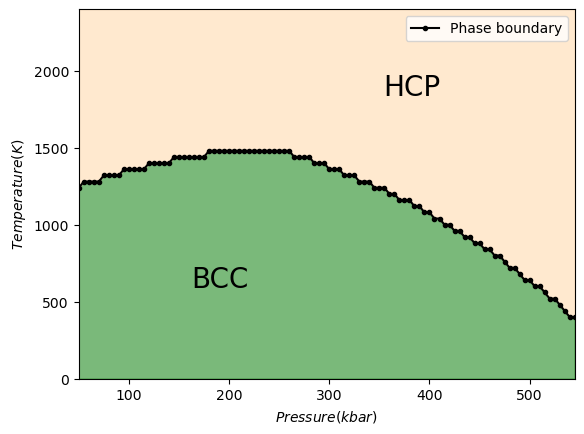

In [26]:
import matplotlib.pyplot as plt

plt.plot(press, pb, color='Black', marker='.', label='Phase boundary')
plt.fill_between(press, pb, color='forestgreen', alpha=.6)
plt.fill_between(press, pb, 2400.0, color='bisque', alpha=.8)
plt.xlim(50,545)
plt.ylim(0,2400)
plt.legend()
plt.xlabel(r'$Pressure (kbar)$')
plt.ylabel(r'$Temperature (K)$')
plt.figtext(0.3, 0.3, 'HCP', size=20)
plt.figtext(0.6, 0.7, 'BCC', size=20)
plt.show()

**Note:** The overall shape and trend of the phase diagram agree well with previous experimental measurements and theoretical calculations. [Olijnyk and Holzapfel (1985)], [Moriarty and Althoff (1995)], and [Mehta et al. (2006)] However, the phase boundary is slightly overestimated. This is because the calculations in this tutorial use unconverged parameters. For more accurate results, one should consider using a denser k-point grid and a higher `ecutwfc` value in the SCF calculations. Converged calculation parameters can be found in the original *epwpy* paper.